# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torchtext
from torchtext.data.utils import get_tokenizer

import random
from sklearn.metrics import mean_squared_error

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
print(device)

cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 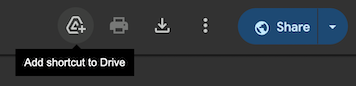

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Скачаем данные для обучения и тестирования:

In [ ]:
dataset = pd.read_csv('salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация
punc.append(' ')

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
X = dataset['FullDescription'].apply(lambda x: x.lower())
y = dataset['SalaryNormalized']

# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in X:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

In [ ]:
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[('experience', 347759),
 ('role', 238196),
 ('work', 227937),
 ('team', 218119),
 ('business', 216114),
 ('skills', 191810),
 ('working', 181537),
 ('within', 177697),
 ('sales', 170521),
 ('client', 160971)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in X]
target = [float(value) for value in y]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  25000, 25000, 25000, 146, 21, 25000, 25000, 1492, 25000, 38, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  25000, 9, 25000, 15, 25000, 25000, 407, 171, 129, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  559, 197, 417, 539, 25000, 16043, 25000, 11185, 8444, 24, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.0513, 0.0581, 0.1154, ...


Сформируйте даталоадеры для обучения и валидации.

In [ ]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, num_layers=2, batch_first=True)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        embedded = self.emb(x)
        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(embedded)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        predictions = self.classifier(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """
    # mean_preds = torch.squeeze(torch.mean(preds, dim=0))
    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()
        texts, target = batch
        texts = texts.to(device)
        target = target.squeeze().to(device)
        predictions = model(texts).squeeze(2)
        predictions = torch.mean(predictions, dim=0)
        # print(target)

        loss = criterion(predictions, target)
        mse_loss = mse(predictions, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()

        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, target = batch
            texts = texts.to(device)
            target = target.squeeze().to(device)
            predictions = model(texts).squeeze(2)
            predictions = torch.mean(predictions, dim=0)

            loss = criterion(predictions, target)
            mse_loss = mse(predictions, target)

            epoch_loss += loss.item()
            epoch_mse += mse_loss.item()

            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)

def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [ ]:
# Задайте параметры сети
model = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=256,
).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

# Посмотрите на получившуюся модель
model

SimpleRNNRegressor(
  (emb): Embedding(25002, 100, padding_idx=25001)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

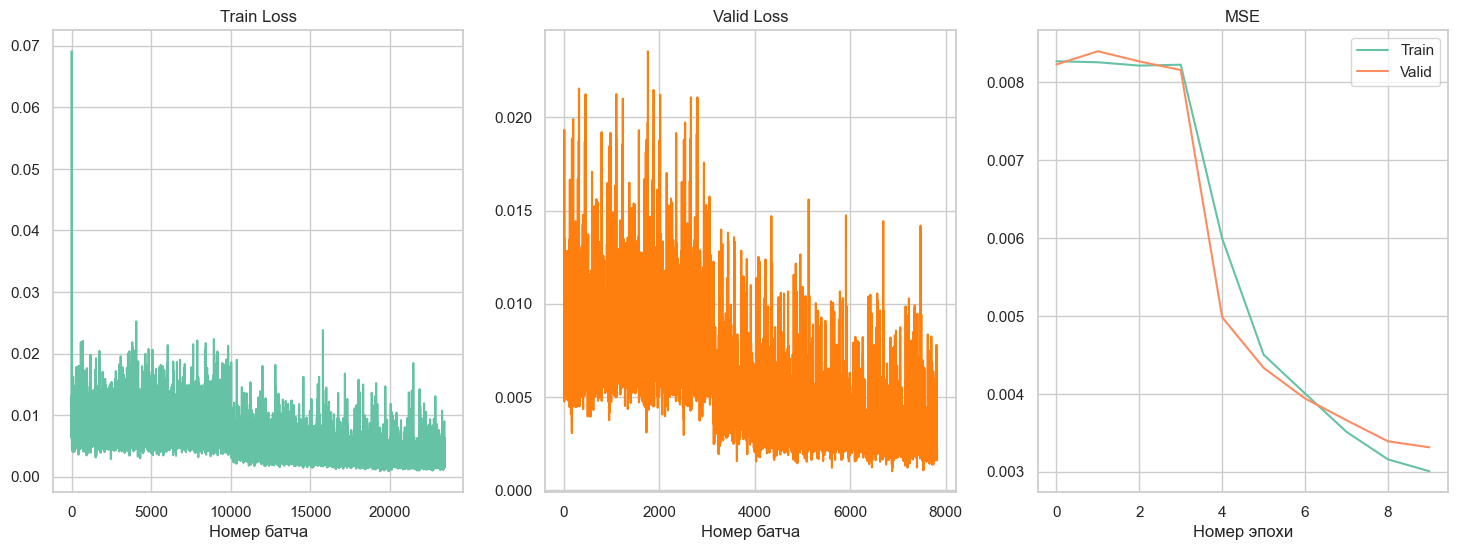

Номер эпохи: 10 | Время обучения эпохи: 3m 57s


In [ ]:
training_loop(model)

Данная модель получилась сильно лучше, чем константа, но, конечно, не идеал. До этого я перепробовал огромное количество вариантов с разными параметрами (менял и количество слоев в LSTM, и размер словаря, и размеры эмбединга и количество скрытых блоков). Как показала практика, далеко не обязательно ставить огромные значения для параметров (они были, обучение одной эпохи занимало до 15 минут).

In [ ]:
print("Результаты первой модели:")

predictions = []
true_values = []

random_index = random.randint(0, len(valid_loader) - 1)

# Получаем батч по случайному индексу
random_batch = None
for i, batch in enumerate(valid_loader):
    if i == random_index:
        random_batch = batch
        break

# Теперь можно получить тексты и метки из случайного батча
texts, target = random_batch

texts = texts.to(device)
with torch.no_grad():
    output = model(texts).squeeze(2)
    output = torch.mean(output, dim=0)

output = scaler.inverse_transform(output.cpu().numpy().reshape(-1, 1)).flatten()
target = scaler.inverse_transform(target.cpu().numpy().reshape(-1, 1)).flatten()

# Добавляем предсказания и истинные значения в списки
predictions.extend(output)
true_values.extend(target)

print(f"Пример {i+1}:")
# print(texts.shape)
for i, tokens in enumerate(texts):
    # text = ' '.join([vocab.lookup_token(token) for token in tokens])
    # print("Текст вакансии:", text)
    print("Предсказание модели:", output[i])
    print("Истинное значение зарплаты:", target[i])
    print()
    if i > 10: break

# Вычисляем среднеквадратичную ошибку на всей тестовой выборке
mse_loss = mean_squared_error(true_values, predictions)
print("Среднеквадратичная ошибка (MSE) на тестовой выборке:", mse_loss)

Результаты первой модели:
Пример 56:
Предсказание модели: 30094.998
Истинное значение зарплаты: 30500.002

Предсказание модели: 22587.234
Истинное значение зарплаты: 27500.002

Предсказание модели: 14305.682
Истинное значение зарплаты: 12960.0

Предсказание модели: 38189.812
Истинное значение зарплаты: 22500.0

Предсказание модели: 54684.836
Истинное значение зарплаты: 50000.004

Предсказание модели: 24896.066
Истинное значение зарплаты: 25440.002

Предсказание модели: 16110.242
Истинное значение зарплаты: 17280.0

Предсказание модели: 30914.703
Истинное значение зарплаты: 47500.0

Предсказание модели: 36999.93
Истинное значение зарплаты: 46087.0

Предсказание модели: 34843.84
Истинное значение зарплаты: 37500.0

Предсказание модели: 66888.14
Истинное значение зарплаты: 50000.004

Предсказание модели: 17131.414
Истинное значение зарплаты: 21446.0

Среднеквадратичная ошибка (MSE) на тестовой выборке: 138116450.0


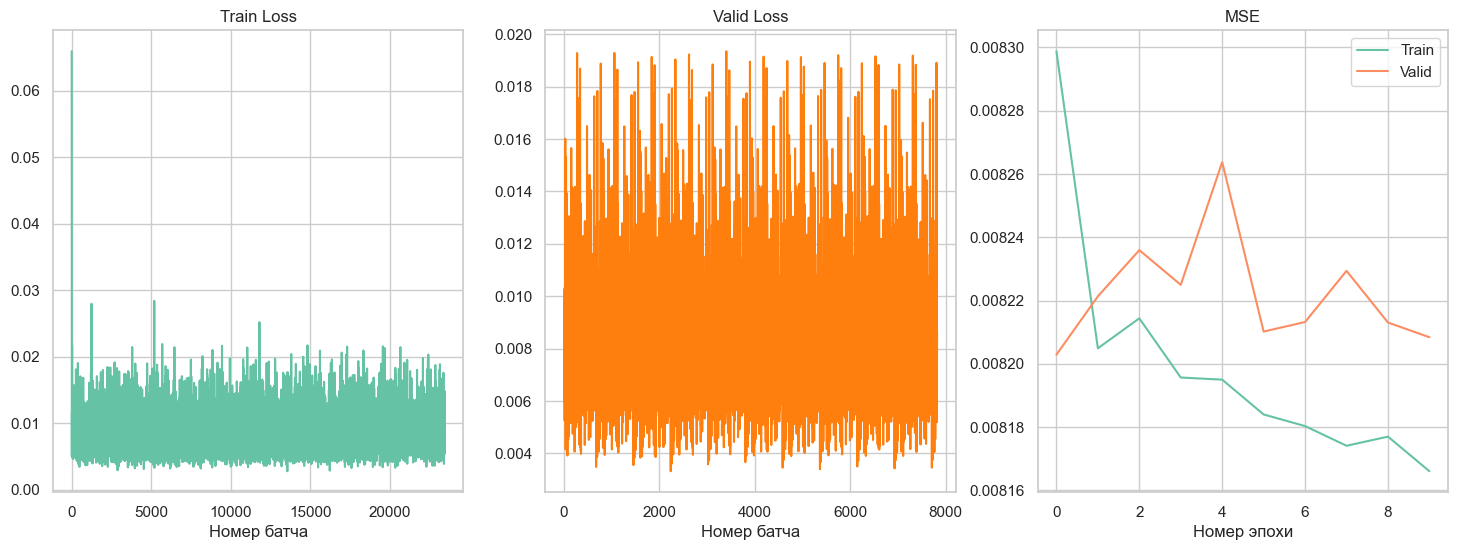

Номер эпохи: 10 | Время обучения эпохи: 3m 20s


In [ ]:
model2 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=128,
).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.005)
history = []

training_loop(model2)

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [ ]:
print("Результаты второй модели:")

predictions = []
true_values = []

random_index = random.randint(0, len(valid_loader) - 1)

# Получаем батч по случайному индексу
random_batch = None
for i, batch in enumerate(valid_loader):
    if i == random_index:
        random_batch = batch
        break

# Теперь можно получить тексты и метки из случайного батча
texts, target = random_batch

texts = texts.to(device)
with torch.no_grad():
    output = model2(texts).squeeze(2)
    output = torch.mean(output, dim=0)

output = scaler.inverse_transform(output.cpu().numpy().reshape(-1, 1)).flatten()
target = scaler.inverse_transform(target.cpu().numpy().reshape(-1, 1)).flatten()

# Добавляем предсказания и истинные значения в списки
predictions.extend(output)
true_values.extend(target)

print(f"Пример {i+1}:")
# print(texts.shape)
for i, tokens in enumerate(texts):
    # text = ' '.join([vocab.lookup_token(token) for token in tokens])
    # print("Текст вакансии:", text)
    print("Предсказание модели:", output[i])
    print("Истинное значение зарплаты:", target[i])
    print()
    if i > 10: break

# Вычисляем среднеквадратичную ошибку на всей тестовой выборке
mse_loss = mean_squared_error(true_values, predictions)
print("Среднеквадратичная ошибка (MSE) на тестовой выборке:", mse_loss)

Результаты второй модели:
Пример 531:
Предсказание модели: 34336.453
Истинное значение зарплаты: 35000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 12734.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 40000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 35000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 30000.002

Предсказание модели: 34336.453
Истинное значение зарплаты: 90000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 62499.004

Предсказание модели: 34336.453
Истинное значение зарплаты: 25000.002

Предсказание модели: 34336.453
Истинное значение зарплаты: 70000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 45000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 72000.0

Предсказание модели: 34336.453
Истинное значение зарплаты: 30000.002

Среднеквадратичная ошибка (MSE) на тестовой выборке: 280452160.0


**Вывод:** очень важно разобраться в архитектуре модели до обучения и использования, иначе получается какое-то гадание. Так же важно подготовить данные правильно, убрать какую-то лишнюю информацию, например, в этом датасете есть несколько пробелов и тогда при получении токенов будет токен пробела, который нам абсолютно не нужен, и в датасете много стоп-слов с большой буквы, которые в итоге не удаляются, соответственно, надо во всех текстах сделать только нижний регистр.
Для получения не констных значений мне потребовалось изменить количество слоев в LSTM, чтобы обрабатывать более сложные зависимости.

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [2]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [7]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

In [11]:
prompt = """
I need your help in predicting salaries for job openings. I have 5 examples where first there is a text description of the vacancy, and then the salary for this vacancy. After this there will be a text vacancies where you have to predict their salary. That is, you only need to name the number.

Examples:
Example 1:'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'
The salary is 55000

Example 2:'Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, JavaScript, AJAX, XML, XSLT and CSS. You will be able to design/develop and maintain databases using SQL and stored producers. You will have excellent problem solving skills and able to manage projects to tight declines. This is an excellent development role with great career progression'
The salary is 27500

Example 3:'MS SQL Database Administrator  Helsinki, Finland SEC Recruitment in London is currently executing a search for a highly skilled MS SQL Database Administrator for a **** month initial contract opportunity to work in the city of Helsinki in Finland. The Project language is English. Duration  6 months. Location  Helsinki, Finland. Rate  Negotiable Language  English. Experience and skills required: Strong relevant experience as MS SQL Database Administrator.  Knowledge of MS SQL windows version **** **** **** and 2012.  Telecoms sector experience will be an advantage.  Fluent English. Start date: ASAP. Technical Requirements  Installation Prerequisites  Kernel Parameters  Database Cloning  Knowledge of Advanced Replication  Initialization Parameters  Backup and Recovery Strategies  Planning and scheduling Backups, Database Recovery, taking Logical Backups Physical Backups.  Hands on experience of Recovery scenarios.  Experience in Capacity Planning, Space Management, Database Upgrades / Migration Data Extraction.  Support to team members for any database related issue  Designing strategy towards Capacity Management for DB tracks.  Having experience of DR setup through various synch methods.  Database Tuning  Tuning Applications, Tuning Memory, and Tuning Disk Usage.  Upgrading and applying security patches.  Managing Alerts and Notifications  Blackout Administration  Cross platform transportable Tablespaces  Installation, Maintenance/Patching and Configuration of SQL Server Certification requirements  MCTS / MCTIP More information available on application. In order to register your interest, please send your CV to michael.khalilsecrecruitment.com and we will contact you to discuss further details. This job was originally posted as www.cwjobs.co.uk/JobSeeking/MSSQLDatabaseAdministratorHelsinkiFinland_job****'
The salary is 72098

You need to name the salary for those jobs:

'We are a new fast growing Internet/Telecoms company Klick2Contact (), established in 2010 which offers a full intuitive suite of Live Help services to companies thought the UK and Europe with ecommerce websites. These services help increase their online sales and decrease their website abandonment and more besides We have customers like Next plc and Yodel and Ryanair in the UK and customers all across Europe too. We want experienced, enthusiastic telesales people to work from home and make appointments for our UK sales people and to sell to small companies on the phone as well. We provide full training and marketing back up via ecasts, web and collateral and both a good salary and commission and you can work from home anywhere in the UK. We will pay for your phone calls and your internet. Why not become part of our future success? We will consider Part Time too. ****  **** depending on experience. Phone bill and internet paid too.'
The salary is ...
"""
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>
I need your help in predicting salaries for job openings. I have 5 examples where first there is a text description of the vacancy, and then the salary for this vacancy. After this there will be a text vacancies where you have to predict their salary. That is, you only need to name the number.

Examples:
Example 1:'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

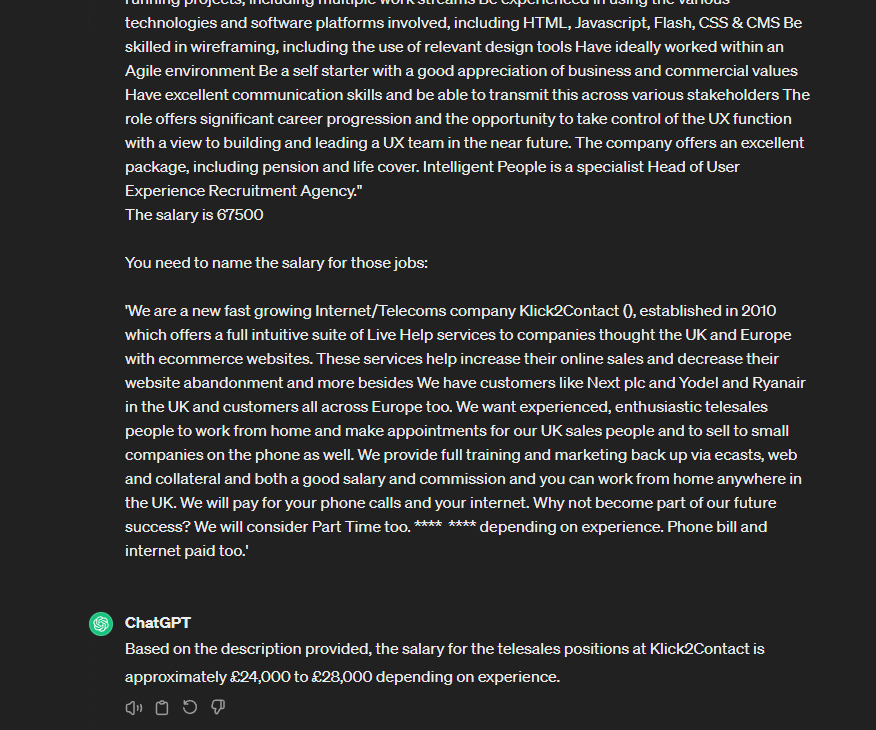

**Вывод:** для использования LLM нужно тренировать навык написания промтов, иначе модели выдают не то, что хотелось бы. Так на моем примере видно, что модель не показывает зарплату, а только выводит ввод и то не до конца.

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*